In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import pmdarima as pm
from sklearn.svm import SVR
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

import tensorflow as tf
print('Configurando TF')
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

look_back = 100
forward_days = 30
num_periods = 20

Configurando TF


In [13]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1,  scale=True):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        d = data[i:i+look_back+forward_days]
        if scale == True:
            d = MinMaxScaler().fit_transform( d )
        X.append(d[:look_back])
        Y.append(d[look_back:look_back+forward_days])
    return np.array(X),np.array(Y)
    
def plot_error(hist):
    pyplot.plot(hist['loss'])
    pyplot.plot(hist['val_loss'])
    pyplot.legend(['train', 'validation'], loc='upper left')
    
#from keras import backend as K
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    SS_res =  K.sum(K.square( actual-forecast ))
    SS_tot = K.sum(K.square( actual - K.mean(actual) ) )
    R2 = 1 - SS_res/(SS_tot + K.epsilon()) 
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, #'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

# Entrenar modelo AAPL

In [3]:
df_train = pd.read_feather("/home/benayas/datasets/lstm/train/train.feather")
appl = df_train[df_train['SYMBOL']=='AAPL']
array = appl['ADJ_CLOSE'].values.reshape(appl.shape[0],1)

In [6]:
# Normalize data and compile model

X,y = processData(array,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.10, random_state=42)

#Training the LSTM
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 15

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
# Entrenar el modelo
history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=1)
model.save('model_apple.h5')

Train on 7839 samples, validate on 872 samples
Epoch 1/15
7839/7839 [==============================] - 645s 82ms/sample - loss: 0.0507 - val_loss: 0.0402
Epoch 2/15
7839/7839 [==============================] - 643s 82ms/sample - loss: 0.0386 - val_loss: 0.0338
Epoch 3/15
7839/7839 [==============================] - 646s 82ms/sample - loss: 0.0316 - val_loss: 0.0284
Epoch 4/15
7839/7839 [==============================] - 643s 82ms/sample - loss: 0.0301 - val_loss: 0.0267
Epoch 5/15
7839/7839 [==============================] - 636s 81ms/sample - loss: 0.0285 - val_loss: 0.0259
Epoch 6/15
7839/7839 [==============================] - 641s 82ms/sample - loss: 0.0267 - val_loss: 0.0249
Epoch 7/15
7839/7839 [==============================] - 642s 82ms/sample - loss: 0.0256 - val_loss: 0.0245
Epoch 8/15
7839/7839 [==============================] - 643s 82ms/sample - loss: 0.0247 - val_loss: 0.0229
Epoch 9/15
7839/7839 [==============================] - 642s 82ms/sample - loss: 0.0241 - val_los

In [21]:
# Train SVR
svr = SVR(kernel='rbf', C=100)
svr = svr.fit(X.reshape(X.shape[0], X.shape[1]), np.array([a[0] for a in y]))

# Test

In [22]:
# Cargar datos test
df_test = pd.read_feather("/home/benayas/datasets/lstm/test/test.feather")
appl_test = df_test[df_test['SYMBOL']=='AAPL']
array_test = appl_test['ADJ_CLOSE'].values.reshape(appl_test.shape[0],1)

X_test,y_test = processData(array_test,look_back,forward_days, jump=num_periods, scale=False)

In [23]:
print('X shape {0}'.format(X_test.shape))
print('Y shape {0}'.format(y_test.shape))

X shape (22, 100, 1)
Y shape (22, 30, 1)


## Test con modelo entrenado en 1 valor (AAPL)

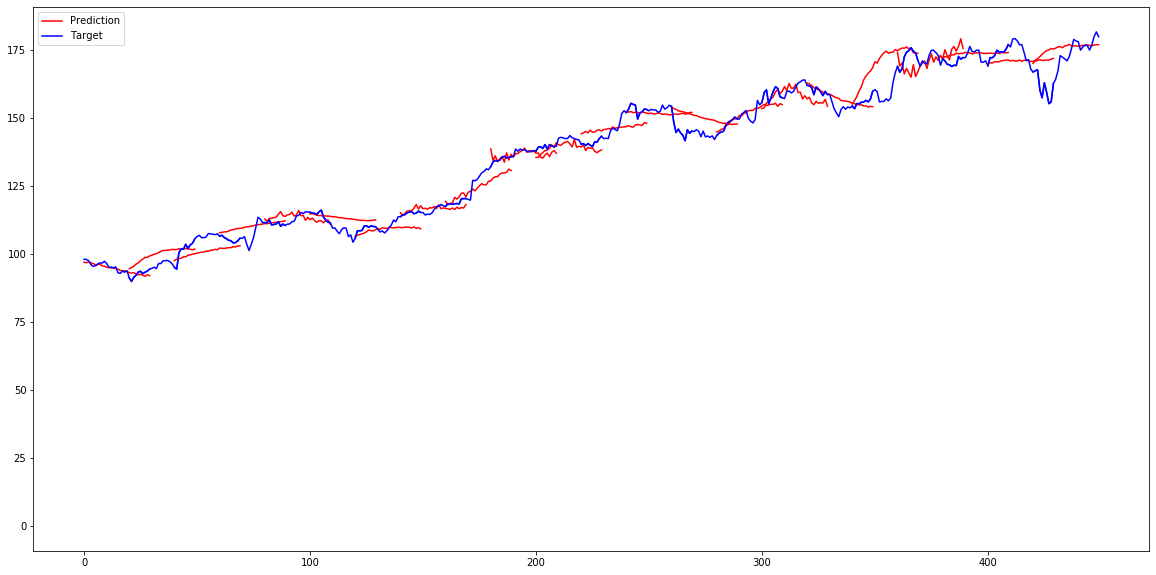

In [24]:
plt.figure(figsize = (20,10))

for i in range(0,len(X_test)):
    scl = MinMaxScaler()
    scl.fit(X_test[i])
    scl.fit(y_test[i])
    d = scl.transform( X_test[i] )
    y_pred = model.predict( d.reshape(1,d.shape[0],1) )
    y_pred = y_pred.reshape(-1,1)
    #plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    plt.plot([x + i*num_periods for x in range(len(y_pred))], scl.inverse_transform(y_pred.reshape(-1,1)), color='r')
    plt.plot([x + i*num_periods for x in range(len(y_test[i]))], y_test[i], color='b')

plt.plot(0, 0, color='r', label='Prediction') #only to place the label
plt.plot(0,0,color='b', label='Target')
plt.legend(loc='best')
plt.show()

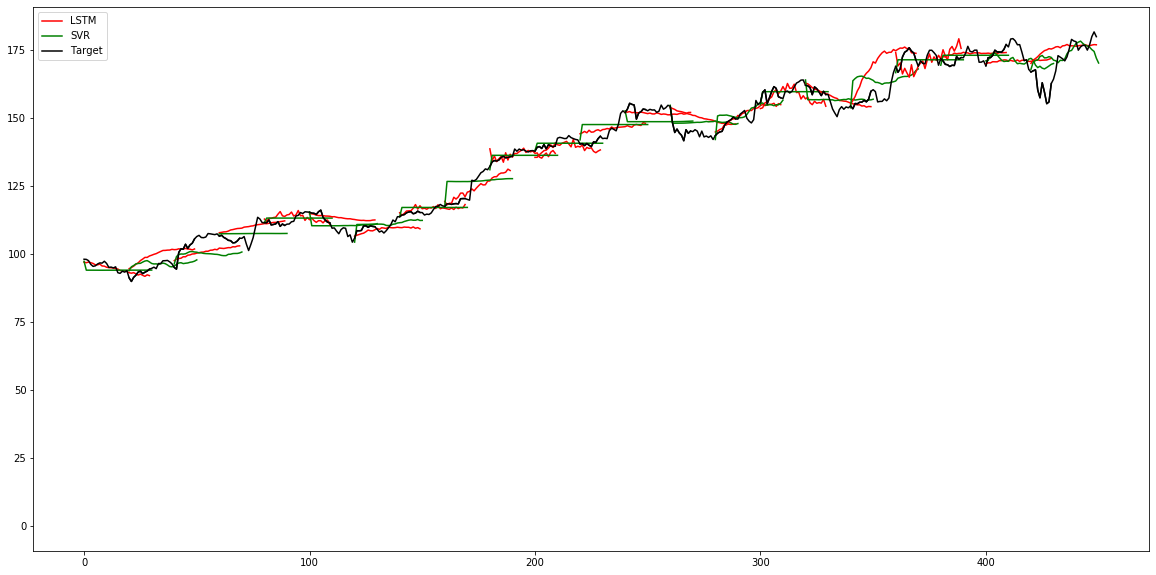

In [29]:
# Comparar contra SVR

plt.figure(figsize = (20,10))

for i in range(0,len(X_test)):
    scl = MinMaxScaler()
    scl.fit(X_test[i])
    scl.fit(y_test[i])
    d = scl.transform( X_test[i] )
    
    # LSTM
    y_pred = model.predict( d.reshape(1,d.shape[0],1) )
    y_pred = y_pred.reshape(-1,1)
    plt.plot([x + i*num_periods for x in range(len(y_pred))], scl.inverse_transform(y_pred.reshape(-1,1)), color='r')
    
    # SVR
    y_pred = []  
    for j in range(0,len(y_test[i])):
        if j == 0:
            y_pred.append(d[-1:][0])
        pred = svr.predict(d[-100:].reshape(1,100))
        d = np.concatenate([d,pred.reshape(1,1)])
        y_pred.append(pred)
    y_pred = np.array(y_pred).reshape(-1,1)
    plt.plot([x + i*num_periods for x in range(len(y_pred))], scl.inverse_transform(y_pred.reshape(-1,1)), color='g')
    
    # Actual values
    plt.plot([x + i*num_periods for x in range(len(y_test[i]))], y_test[i], color='k')

plt.plot(0,0, color='r', label='LSTM') #only to place the label
plt.plot(0,0, color='g', label='SVR') #only to place the label
plt.plot(0,0, color='k', label='Target')
plt.legend(loc='best')
plt.show()

/home/benayas/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/benayas/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/benayas/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/benayas/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignore

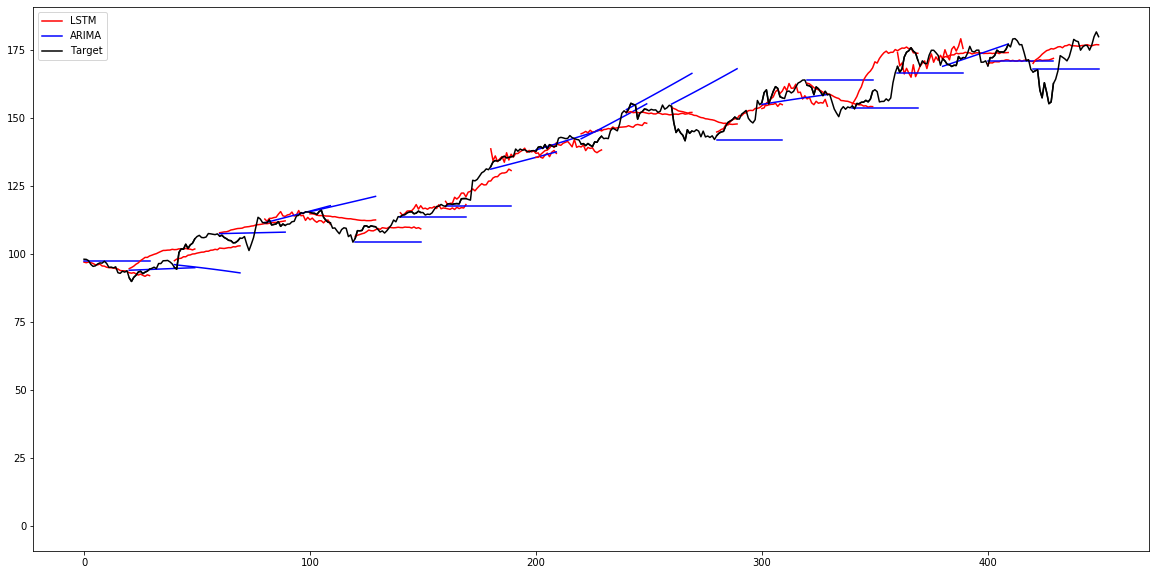

In [32]:
# Comparar contra ARIMA
plt.figure(figsize = (20,10))

for i in range(0,len(X_test)):
    scl = MinMaxScaler()
    scl.fit(X_test[i])
    scl.fit(y_test[i])
    d = scl.transform( X_test[i] )
    
    # LSTM
    y_pred = model.predict( d.reshape(1,d.shape[0],1) )
    y_pred = y_pred.reshape(-1,1)
    plt.plot([x + i*num_periods for x in range(len(y_pred))], scl.inverse_transform(y_pred.reshape(-1,1)), color='r')
    
    # ARIMA
    stepwise_fit = pm.auto_arima(np.log(X_test[i]), start_p=1, start_q=1, test='adf', max_p=10, max_q=5, m=7,
                             start_P=0, seasonal=False, d=None, D=0, trace=False,
                             error_action='ignore', suppress_warnings=True, stepwise=True)
    fc= stepwise_fit.predict(n_periods=len(y_test[i]), return_conf_int=False)
    y_pred = np.exp(fc)
    y_pred = y_pred.reshape(-1,1)
    plt.plot([x + i*num_periods for x in range(len(y_pred))], y_pred, color='b')
    
    # Actual values
    plt.plot([x + i*num_periods for x in range(len(y_test[i]))], y_test[i], color='k')

plt.plot(0,0, color='r', label='LSTM') #only to place the label
plt.plot(0,0, color='b', label='ARIMA') #only to place the label
plt.plot(0,0, color='k', label='Target')
plt.legend(loc='best')
plt.show()